In [ ]:
import zipfile
import os

# Step 3: Specify the zip file path and extraction folder path
# Replace 'your-zip-file.zip' with the actual path of your uploaded zip file.
# You can upload the zip file to the Colab environment or to Google Drive.

zip_file_path = '/content/drive/MyDrive/kidney.zip'  # Path to the uploaded zip file
extraction_folder = '/content/drive/MyDrive/KidneyDataset'  # Destination folder in Google Drive

# Step 4: Ensure the extraction folder exists
os.makedirs(extraction_folder, exist_ok=True)

# Step 5: Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

print(f"Files extracted to: {extraction_folder}")

Files extracted to: /content/drive/MyDrive/KidneyDataset


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imutils import paths

In [ ]:
# Specify the directory where the files are stored
cyst_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Cyst'))
normal_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Normal'))
stone_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Stone'))
tumor_ImagePaths = list(paths.list_images('/content/drive/MyDrive/KidneyDataset/CTKIDNEYDATASETNormalCystTumorStone/CTKIDNEYDATASETNormalCystTumorStone/Tumor'))

# Initialize lists to store image data and labels
data = []
labels = []

# Function to preprocess images and append to data and labels
def preprocess_and_append(imagePaths, label, data, labels, img_size=(64, 64)):
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, img_size)
        image = image / 255.0  # Normalize to [0, 1]
        data.append(image)
        labels.append(label)

# Preprocess and append images for each class
preprocess_and_append(cyst_ImagePaths, 'cyst', data, labels)
preprocess_and_append(normal_ImagePaths, 'normal', data, labels)
preprocess_and_append(stone_ImagePaths, 'stone', data, labels)
preprocess_and_append(tumor_ImagePaths, 'tumor', data, labels)


# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)



In [ ]:
# Map string labels to numeric values
label_mapping = {
    'cyst': 0,
    'normal': 1,
    'stone': 2,
    'tumor': 3,

}
numeric_labels = np.array([label_mapping[label] for label in labels])

# Convert numeric labels to one-hot encoded labels
one_hot_labels = to_categorical(numeric_labels, num_classes=len(label_mapping))

# Verify the shape of the data and one-hot encoded labels
print("Shape of data:", data.shape)
print("Shape of one-hot encoded labels:", one_hot_labels.shape)


Shape of data: (12446, 64, 64, 3)
Shape of one-hot encoded labels: (12446, 4)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42)


In [ ]:
X_train.shape


(9956, 64, 64, 3)

In [ ]:
X_test.shape


(2490, 64, 64, 3)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout


# Load the VGG16 model, without the top layer (which is the fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add new top layers (classification head)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a different learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Verify the model summary
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 33,553,796 (128.00 MB)

 Trainable params: 9,966,084 (38.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 185s 715ms/step - accuracy: 0.4572 - loss: 1.2982 - val_accuracy: 0.6516 - val_loss: 0.8986
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 202s 718ms/step - accuracy: 0.6494 - loss: 0.8828 - val_accuracy: 0.7505 - val_loss: 0.6565
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 188s 756ms/step - accuracy: 0.7402 - loss: 0.6745 - val_accuracy: 0.7937 - val_loss: 0.5384
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 191s 710ms/step - accuracy: 0.7590 - loss: 0.6243 - val_accuracy: 0.7902 - val_loss: 0.5497
Epoch 5/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 217s 771ms/step - accuracy: 0.7929 - loss: 0.5406 - val_accuracy: 0.7676 - val_loss: 0.5805


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 446ms/step - accuracy: 0.7773 - loss: 0.5554
Test accuracy: 0.7787148356437683


In [ ]:
y_pred = model.predict(X_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 472ms/step


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class index with the highest probability
y_test_classes = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded


In [ ]:
# Use the converted class labels
confusion_mat = confusion_matrix(y_test_classes, y_pred_classes)
print('Confusion Matrix: \n', confusion_mat)

Confusion Matrix: 
 [[ 563  125   42   35]
 [   2 1005    0    8]
 [  40  133   79   24]
 [   6  132    4  292]]


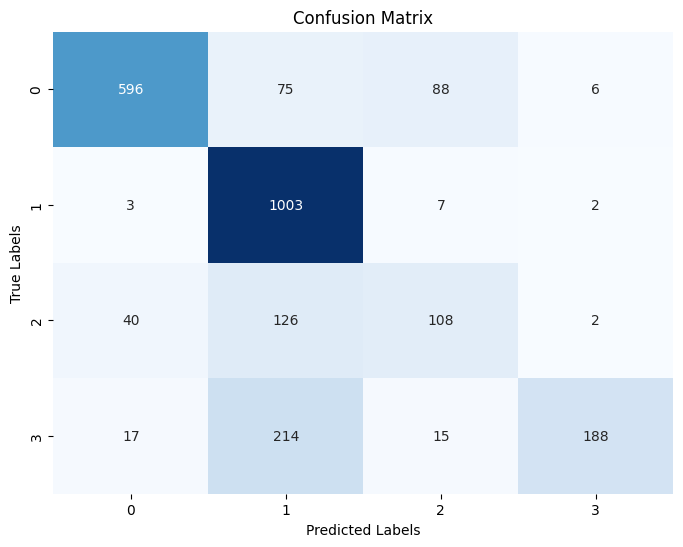

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       765
           1       0.71      0.99      0.82      1015
           2       0.50      0.39      0.44       276
           3       0.95      0.43      0.59       434

    accuracy                           0.76      2490
   macro avg       0.77      0.65      0.67      2490
weighted avg       0.79      0.76      0.75      2490



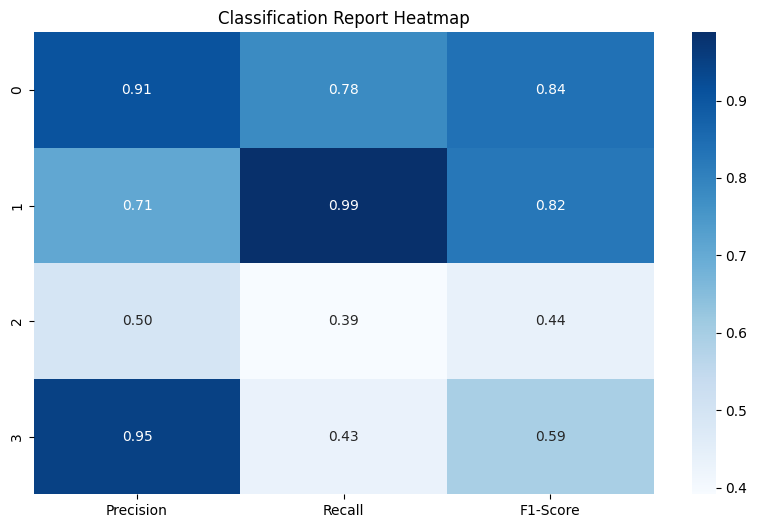

In [ ]:
# Plotting a heatmap for precision, recall, and F1-score
class_report = classification_report(y_test_classes, y_pred_classes, output_dict=True)
class_names = [str(label) for label in class_report.keys() if label not in ['accuracy', 'macro avg', 'weighted avg']]

# Extract precision, recall, and F1-score for each class
heatmap_data = [[class_report[class_name]['precision'], class_report[class_name]['recall'], class_report[class_name]['f1-score']] for class_name in class_names]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=['Precision', 'Recall', 'F1-Score'], yticklabels=class_names, cmap='Blues')
plt.title('Classification Report Heatmap')
plt.show()